Imports:

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression

from linear_regression import *
from logistic_regression import *

Data Processing:

In [2]:
# converts datetime objects to consecutive ints from start date
def day_to_num(day):
    first_day = all_dates[0]
    first_day =   datetime.strptime(first_day, "%Y-%m-%d")
    day = datetime.strptime(day, "%Y-%m-%d")
    delta = day - first_day
    return delta.days

In [3]:
listings = pd.read_pickle("data/remote_job_post_df.pkl")

# Get a list of all included dates
all_dates = listings['post_date'].unique()
all_dates.sort()
# First Day: 2020-09-30
# Last Day: 2021-09-30

false = []
true = []

# For each date
for date in all_dates:
    
    # Get only the entry from each day
    subset = listings[listings['post_date'] == date]
    # Finds number of rows with each value in is_remote (true/false in this case)
    remote = subset['is_remote'].value_counts()
    
    # The if/else statements take into account if either value is 0
    if 'false' in remote.index:
        false.append(remote['false'])
    else:
        false.append(0)
        
    if 'true' in remote.index:
        true.append(remote['true'])
    else:
        true.append(0)

by_day = pd.DataFrame(list(zip(all_dates, false, true)), columns = ['date', 'not_remote', 'is_remote'])

# Final measure: Proportion remote/total jobs in a day
by_day['prop_remote'] = by_day.apply(lambda x: x.is_remote / (x.is_remote + x.not_remote), axis = 1)
by_day['day_num'] = by_day['date'].apply(day_to_num)

by_day.head()

,date,not_remote,is_remote,prop_remote,day_num
0,2020-09-30,4,0,0.000000,0
1,2020-10-01,427,19,0.042601,1
2,2020-10-02,503,23,0.043726,2
3,2020-10-03,463,29,0.058943,3
4,2020-10-04,157,3,0.018750,4


Data Preview:

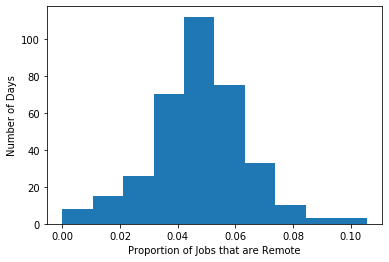

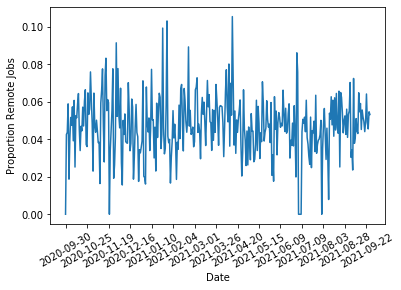

In [4]:
# plots of sorted data
plt.hist(by_day['prop_remote'])
plt.xlabel("Proportion of Jobs that are Remote")
plt.ylabel("Number of Days")
plt.show()

plt.plot(by_day['prop_remote'])
plt.xticks(ticks = range(0, by_day.shape[0], 25), labels = by_day['date'].tolist()[0::25], rotation = 30)
plt.xlabel("Date")
plt.ylabel("Proportion Remote Jobs")
plt.show()

# Simple Linear Regression:

In [5]:
# Initialize x: the day number from 0 to 365
x = np.array(by_day['day_num'].tolist()).reshape(-1,)

# Initialize X: [1, day_num]
X = np.ones([355, 2])
for i in range(by_day.shape[0]):
    X[i, 1] = by_day.at[i, "day_num"]

# initialize y: proportion of remote jobs on a given day
y = np.array([y for y in by_day['prop_remote']]).reshape(-1,)

In [6]:
X.shape

(355, 2)

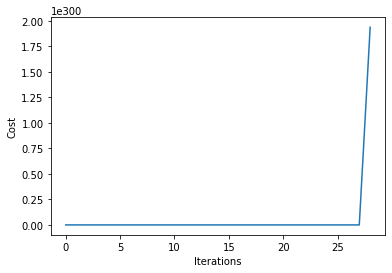

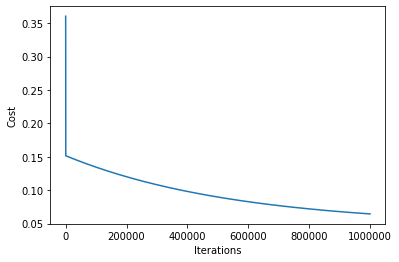

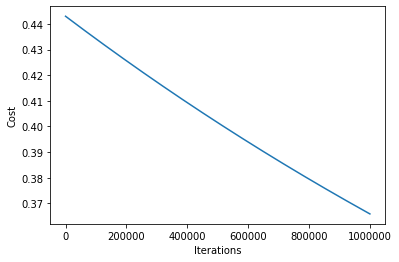

In [7]:
# 10,000,000 takes a while, but looks better
# This is using 1,000,000 for now
for i in range(2, 15, 6):
    iters = 1000000
    alpha = 1 / (10**i)

    theta, J_history = linear_gd(X, y, alpha, iters)

    plt.figure()
    plt.plot(J_history)
    plt.xlabel("Iterations")
    plt.ylabel("Cost")
    plt.show()

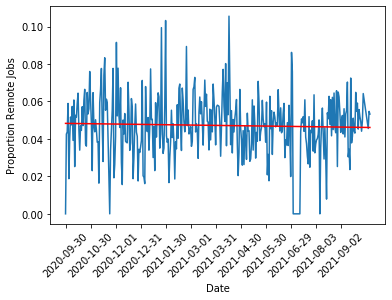

In [8]:
# This can be run with 1,000,000 iterations, but the line isn't as good!
iters = 10000000
alpha = 1 / (10**8)

theta, J_history = linear_gd(X, y, alpha, iters)

plt.figure()
y_predict = np.dot(X, theta)
plt.plot(x, y)
plt.plot(x, y_predict, "-r")
plt.xticks(ticks = range(0, by_day.shape[0], 30), labels = by_day['date'].tolist()[0::30], rotation = 45)
plt.xlabel("Date")
plt.ylabel("Proportion Remote Jobs")
plt.show()

In [9]:
print("intercept:", theta[0])
print("slope:", theta[1])

intercept: 0.04830296786678959
slope: -5.984333862204281e-06


# Linear Regression with Feature Expansion:

To determine the ideal degree polynomial to predict the proportion of jobs that are remote per day, we will test polynomials of different degrees on a training and testing dataset to avoid overfitting. This will be done with SKLearn's LinearRegression because different degree polynomials might perform best with different $\alpha$ values, so this way it will be a fair comparison.

In [12]:
#### Initializing Variables, Separate into Train/Test Sets ####

np.random.seed(9)

# Randomly select 3/4 of the indices for the train set
train_indices = np.random.choice(x.shape[0], size = (x.shape[0] * 3) // 4, replace = False)
train_indices.sort()

# The indices not in the train set are in the test set
test_indices = np.array([i for i in range(x.shape[0]) if i not in train_indices])

# Separate x into train/test
x_train = x[train_indices]
x_test = x[test_indices]

# Separate y into train/test
y_train = y[train_indices]
y_test = y[test_indices]

In [13]:
def feature_expansion(x_base, poly = 2):
    '''
    Use feature expansion to transform a single feature
    vector into a multiple feature vector where the new
    features are terms in a polynomial.
    
    Inputs:
        X       m x 1 data matrix
        poly    degree of the polynomial (default 2)
    Output:
        X_fe    m x poly data matrix
    '''
    X_fe = np.zeros([poly + 1, x_base.shape[0]])
    
    for i in range(poly + 1):
        X_fe[i] = np.array([num**i for num in x_base])
        
    X_fe = X_fe.T
    
    return X_fe

In [14]:
#### Testing different degree polynomials ####

degree = 10

# Initializing to store cost
training_cost = np.zeros(degree)
testing_cost = np.zeros(degree)

for i in range(1, degree + 1):
    # Feature expansion
    X_train_fe = feature_expansion(x_train, i)
    X_test_fe = feature_expansion(x_test, i)
    
    # Linear Regression    
    model = LinearRegression().fit(X_train_fe, y_train)
    
    # Get the cost for the training dataset
    training_cost[i - 1] = linear_cost_function(X_train_fe, y_train, model.coef_)
    
    # Get the cost for the testing dataset
    testing_cost[i - 1] = linear_cost_function(X_test_fe, y_test, model.coef_)

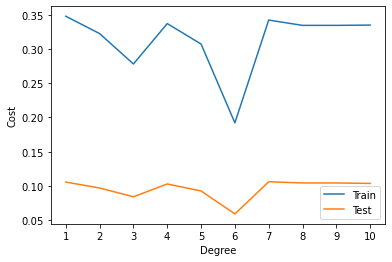

In [15]:
plt.plot(training_cost, label = 'Train')
plt.plot(testing_cost, label = 'Test')
plt.legend()
plt.xticks(ticks = range(0, 10), labels = range(1, 11))
plt.xlabel("Degree")
plt.ylabel("Cost")
plt.show()

Not only does ```degree = 6``` have the lowest cost, it also has the smallest training/testing gap. 

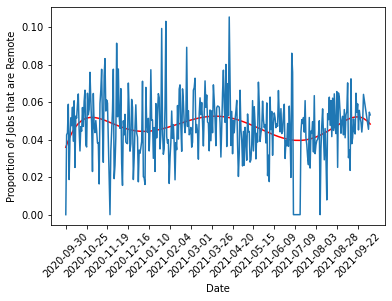

In [16]:
# Feature expansion for degree = 6
X_fe = feature_expansion(x, 6)

# Linear Regression Model
model = LinearRegression().fit(X_fe, y)

# Use model to predict X values
y_predict = model.predict(X_fe)

plt.plot(x.reshape(-1, 1), y_predict, "-r")
plt.plot(x.reshape(-1, 1), y)
plt.xticks(ticks = range(0, 355, 25), labels = [all_dates[i] for i in range(0, 355, 25)], rotation = 45)
plt.xlabel("Date")
plt.ylabel("Proportion of Jobs that are Remote")
plt.show()

In [17]:
print("Intercept: ", model.intercept_)
print("Coefficients: ", model.coef_)

Intercept:  0.035999207186741766
Coefficients:  [ 0.00000000e+00  1.28821827e-03 -3.51649656e-05  3.85757455e-07
 -1.96947709e-09  4.67770168e-12 -4.17786465e-15]


All in all, it also looks like a pretty good fit! 

# Logistic Regression: Remotability

Given a set of features, the model predicts whether a job is remote or not. Whether the job is in fact remote or not, this probability serves a measure of how "remotable" a job is, since jobs with similar features were able to made remote.

In [18]:
#### Preparing the Data ####

listings_features = pd.read_pickle("data/has_salary_df.pkl")

# initialize X
X = np.zeros((len(listings), 3))

# populate X with features
categories = listings_features['category'].unique()
for i in range(len(listings_features)):
    # post date feature
    X.T[0][i] = day_to_num(listings_features['post_date'][i])
    # job category feature
    for j in range(len(categories)):
        if listings_features['category'][i] == categories[j]:
            X.T[1][i] = j
    # salary feature
    X.T[2][i] = listings_features['mean_salary_range'][i]


# intialize y to be 1 for remote, 0 otherwise
y = np.array([int(y == 'true') for y in listings["is_remote"]])


In [19]:
#### Initializing Variables, Separate into Train/Test Sets ####

np.random.seed(9)

# Randomly select 3/4 of the indices for the train set
train_indices = np.random.choice(X.shape[0], size = (X.shape[0] * 3) // 4, replace = False)
train_indices.sort()

# The indices not in the train set are in the test set
test_indices = np.array([i for i in range(X.shape[0]) if i not in train_indices])

# Separate x into train/test
X_train = X[train_indices]
X_test = X[test_indices]

# Separate y into train/test
y_train = y[train_indices]
y_test = y[test_indices]

In [28]:
#### Train Logistic Model ####

# m, n = X_train.shape

# # initialize hyperparameters
# theta_init = np.zeros(n)
# alpha = 0.001
# iters = 1000
# num_classes = 2

# # use logistic regression implementation
# weight_vectors, intercepts = one_vs_all(X_train, y_train, num_classes, alpha=0.01, iters=1000, theta=theta_init)

# predictions = predict_one_vs_all(X, weight_vectors, intercepts)


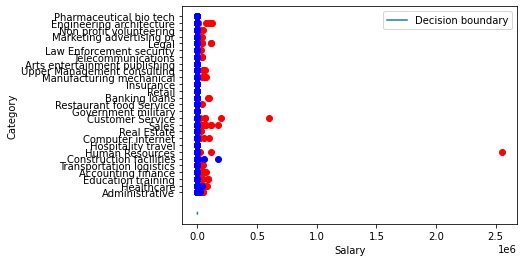

In [27]:
#### Plot Model ####

model = LogisticRegression().fit(X_train, y_train)
b = model.intercept_
w1, w2, w3 = model.coef_.T

# plot the decision boundary
x1_min = np.min(X[:,1]) - 0.5
x1_max = np.max(X[:,1]) + 0.5
theta = model.coef_[0]
x1 = np.array([x1_min, x1_max])
x2 = theta[1]*x1 + theta[1]*x1 + model.intercept_

# plotting the data
plt.scatter(X[y.T==0, 2], X[y.T==0, 1], color='red')
plt.scatter(X[y.T==1, 2], X[y.T==1, 1], color='blue')
plt.yticks(ticks = range(0, 27), labels = [y for y in categories])

plt.ylabel('Category')
plt.xlabel('Salary')
plt.plot(x1, x2, label='Decision boundary')
plt.legend(loc='upper right')
plt.show()

In [24]:
#### Remotability Score ####

def remotability(data_sample, weight_vectors, intercepts):
    '''
    Take in job posting data and return a probability that the job is remote,
    representative of the "remotability" of the job.
    
    Inputs: 
        data_sample       array with three elements: [post_date, category, salary] 
                       
    Outputs:
        remotability      float representing a percentage           
    '''
    vals = data_sample.dot(weight_vectors) + intercepts
    # only return probability for first class, which is remote
    return vals[0]